In [2]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D, Reshape, Activation
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from tensorflow.python.platform import build_info as tf_build_info
from platform import python_version
import tensorflow_addons as tfa

print("Python version: {}".format(python_version()))
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
#print("Cuda version: {}".format(tf_build_info.cuda_version_number))
#print("Cudnn version: {}".format(tf_build_info.cudnn_version_number))
print("Num Physical GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num Logical GPUs Available: ", len(tf.config.experimental.list_logical_devices('GPU')))

NETWORK_W          = 608
NETWORK_H          = 608

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    



def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip: # handle Shorcut -3 
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   use_bias=True)(x)
        
        if conv['bnorm']: x = BatchNormalization(name='BN_' + str(conv['layer_idx']))(x)    
        
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
        if conv['activ'] == 2: x = tfa.activations.mish(x)
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x


def make_yolov4_model():
  
    input_image = Input(shape=(NETWORK_H, NETWORK_W, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x
    
    # Layer  2 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x
    
    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x
    
    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')
    
    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x
    
    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x
    
    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)
    
    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)
    
    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}]) 
    layer_21 = x
    
    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')
    
    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x
    
    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x
    
    # route  24 (layers = -2)
    x = layer_24
    
    # Layer 27 => 29
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 27},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 28},
                        {'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 29}],
                   skip = True)
    
    # Layer 31 => 50
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 31+(i*3)},
                            {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 32+(i*3)}],
                       skip = True)
  
    # Layer  52
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 52}])
    layer_52 = x
        
    # route  52+25 (layers = -1,-28)
    x = concatenate([layer_52, layer_25],  name='concat_53')
    
    # Layer 54
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 54}])
    layer_54 = x
    
    # Layer  55
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 55}])
    layer_55 = x
    
    # Layer  56
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 56}])
    layer_56 = x
    
    # route  55 (layers = -2)
    x = layer_55
    
    # Layer 58 => 60
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 58},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 59},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 60}],
                   skip = True)     

    # Layer 62 => 81
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 62+(i*3)},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 63+(i*3)}],
                       skip = True)

    # Layer  83
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 83}])
    layer_83 = x

    # route  83+56 (layers = -1,-28)
    x = concatenate([layer_83, layer_56], name='concat_84')
    
    # Layer 85
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 85}])
    layer_85 = x
    
    # Layer  86
    x = _conv_block(x, [{'filter':  1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 86}])
    layer_86 = x
    
    # Layer  87
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 87}])
    layer_87 = x
        
    # route  86 (layers = -2)
    x = layer_86
    
    # Layer 89 => 92
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 89},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 90},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 91}],
                   skip = True) 
    
    
    # Layer 93 => 100
    for i in range(3):
        x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 93+(i*3)},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 94+(i*3)}],
                       skip = True)  
    
    
    # Layer  102 => 102
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 102}])  
    layer_102 = x
    
    # route  102+87 (layers = -1,-16)
    x = concatenate([layer_102, layer_87], name='concat_103')
    
    # Layer 104 => 107
    x = _conv_block(x, [{'filter':  1024, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 104},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 105},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106},                        
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 107}])
    layer_107 = x
    
    # Layer 108
    x =MaxPool2D(pool_size=(5, 5), strides=1, padding='same', name = 'layer_108')(x)  
    layer_108 = x
    
    # route  107 (layers = -2)
    x = layer_107
    
    # Layer 110
    x =MaxPool2D(pool_size=(9, 9), strides=1, padding='same', name = 'layer_110')(x)    
    layer_110 = x
    
    # route  107 (layers = -4)
    x = layer_107
        
    # Layer 112
    x =MaxPool2D(pool_size=(13, 13), strides=1, padding='same', name = 'layer_112')(x) 
    layer_112 = x
    
    # route  112+110+108+107 (layers=-1,-3,-5,-6)
    x = concatenate([layer_112, layer_110, layer_108, layer_107], name='concat_113')
    layer_113 = x
    
    # Layer 114 => 116
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 114},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 116}])
    layer_116 = x
                        
    # Layer 117                    
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 117}])
    layer_117 = x
    # Layer 118
    x = UpSampling2D(size=(2, 2), name = 'upsamp_118')(x)
    layer_118 = x
                        
    # route  85 (layers = 85)
    x = layer_85
    
    # Layer 120
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 120}])
    layer_120 = x
                        
    # route  120+118 (layers = -1, -3)
    x = concatenate([layer_120, layer_118],  name='concat_121')
    layer_121 = x                    
    # Layer 122 => 126
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 122},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 123},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 124},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 125},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 126}])
    layer_126 = x 
                        
    # Layer 127                    
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 127}])
    layer_127 = x
    # Layer 128
    x = UpSampling2D(size=(2, 2), name = 'upsamp_128')(x)
    layer_128 = x
                        
    # route  54 (layers = 54)
    x = layer_54
    
    # Layer 130
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 130}])
    layer_130 = x
                        
    # route  130+128 (layers = -1, -3)                 
    x = concatenate([layer_130, layer_128],  name='concat_131')
    layer_131 = x                    
    # Layer 132 => 136
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 133},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 134},  
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 135},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 136}])
    layer_136 = x                   
    
    # Layer 137 => 138
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 137}]) 
    layer_137 = x 
    x = _conv_block(x, [{'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 138}])   
  
    # Layer 139
    yolo_139 = x
                        
    # route  136 (layers = -4)
    x = layer_136
    
    # Layer 141
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 141}])
    layer_141 = x
                        
    # route  141+126 (layers = -1, -16)                   
    x = concatenate([layer_141, layer_126],  name='concat_142')
    
    # Layer 143 => 147
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 143},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 144},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 145},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 146},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 147}])  
    layer_147 = x
                        
    # Layer 148 => 149                    
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 148},
                        {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 149}])
                        
    # Layer 150
    yolo_150 = x                  
    
    # route  147 (layers = -4)
    x = layer_147
        
    # Layer 152
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 152}])
    layer_152 = x  
                        
    # route  152+166 (layers = -1, -37)                   
    x = concatenate([layer_152, layer_116],  name='concat_153') 
                        
                        
    # Layer 154 => 160
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 154},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 155},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 156},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 157},  
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 158},   
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 159},
                        {'filter':   255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 160}])  
                     
                        
    # Layer 161
    yolo_161 = x
                           
    model = Model(input_image, [yolo_139, yolo_150, yolo_161], name = 'Yolo_v4')    
    
    return model

2022-07-22 11:36:01.320004: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Python version: 3.9.12
TensorFlow version: 2.4.1
Eager execution: True
Keras version: 2.4.0
Num Physical GPUs Available:  0
Num Logical GPUs Available:  0


2022-07-22 11:36:03.880641: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-22 11:36:03.880901: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-22 11:36:03.880911: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 11:36:03.880923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mohamed-Latitude-3500): /proc/driver/nvidia/version does not exist
2022-07-22 11:36:03.882514: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, reb

In [3]:
# define the model
model = make_yolov4_model()

In [4]:
model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
BN_0 (BatchNormalization)       (None, 608, 608, 32) 128         convn_0[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 608, 608, 32) 0           BN_0[0][0]                       
____________________________________________________________________________________________

In [5]:
model.layers[-1]


In [6]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(161):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [138, 149, 160]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0

In [7]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov4.weights')
weight_reader.load_weights(model)

FileNotFoundError: [Errno 2] No such file or directory: 'models/yolo/yolov4.weights'

In [ ]:
# save the model to file
! rm models/yolo/yolov4.h5

model.save('models/yolo/yolov4.h5')
! dir models/yolo/*.h5

models/yolo/yolov3-tiny.h5  models/yolo/yolov4.h5


In [8]:
# Load the model
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov4.h5")

In [9]:
# Freeze the backbone

# Fine-tune from this layer onwards
fine_tune_at = "convn_136"

# Freeze all the layers before the `fine_tune_at` layer
train = False
for l in yolo_model.layers:
  if l.name == fine_tune_at:
        train = True        
  l.trainable =  train
    

# Display the trainable indicator
for l in yolo_model.layers:
    print("layer ",l.name, " trainable: ", l.trainable)

layer  input_0  trainable:  False
layer  convn_0  trainable:  False
layer  BN_0  trainable:  False
layer  tf.convert_to_tensor  trainable:  False
layer  tf.math.softplus  trainable:  False
layer  tf.math.tanh  trainable:  False
layer  tf.math.multiply  trainable:  False
layer  zerop_1  trainable:  False
layer  convn_1  trainable:  False
layer  BN_1  trainable:  False
layer  tf.convert_to_tensor_1  trainable:  False
layer  tf.math.softplus_1  trainable:  False
layer  tf.math.tanh_1  trainable:  False
layer  tf.math.multiply_1  trainable:  False
layer  convn_4  trainable:  False
layer  BN_4  trainable:  False
layer  tf.convert_to_tensor_3  trainable:  False
layer  tf.math.softplus_3  trainable:  False
layer  tf.math.tanh_3  trainable:  False
layer  tf.math.multiply_3  trainable:  False
layer  convn_5  trainable:  False
layer  BN_5  trainable:  False
layer  tf.convert_to_tensor_4  trainable:  False
layer  tf.math.softplus_4  trainable:  False
layer  tf.math.tanh_4  trainable:  False
layer

In [10]:
yolo_model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
BN_0 (BatchNormalization)       (None, 608, 608, 32) 128         convn_0[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 608, 608, 32) 0           BN_0[0][0]                       
____________________________________________________________________________________________

In [11]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

sepperating training and validation data

In [12]:
import random
from os import listdir
path = 'data/images/'

t = 0.8

l = listdir(path)
for i  in range(len(l )): 
   l[i] = l[i].split('.')[0]
random.shuffle(l)
training_amount = int(len(l)*t)

training_data = l[:training_amount]
validation_data = l[training_amount:]

train_lables = 'data/train.txt'
val_lables = 'data/val.txt'

train_lables_data = ''
for f in training_data:
   train_lables_data+= f+ '\n'

val_lables_data = ''
for f in validation_data:
   val_lables_data+= f+ '\n'

with open(train_lables,'w') as train_file:
   train_file.write(train_lables_data)

with open(val_lables,'w') as val_file:
   val_file.write(val_lables_data)







In [13]:
# Load the labels
labels = read_labels('data/classes.txt')
print(labels)
print("Nb labels:", len(labels))

['D00', 'D10', 'D20', 'D40', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Nb labels: 80


In [14]:
NETWORK_W        = 608
NETWORK_H        = 608
NB_BOX           = 3
NB_CLASS         = len(labels)
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
grids = [(76,76), (38,38), (19,19)]
anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
scales_x_y = [1.2, 1.1, 1.05]
NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 50
TRUE_BOX_BUFFER  = 50

In [15]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
     
        

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union


class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score

In [16]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join

def convert(image_wh, box, grid_w, grid_h, Boxanchor, yolo_id):
    dw = image_wh[0]/ grid_w
    dh = image_wh[1]/ grid_h
    center_x = (box[0] + box[1])/2.0
    center_x = center_x / dw
    center_y = (box[2] + box[3])/2.0
    center_y = center_y / dh
    
    grid_x = int(np.floor(center_x))
    grid_y = int(np.floor(center_y))
    
    if grid_x < grid_w and grid_y < grid_h:
        w = (box[1] - box[0]) / dw
        h = (box[3] - box[2]) / dh
        
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou     = -1
    
        shifted_box = BoundBox(0,0,w,h)
    
        for i in range(len(anchors[yolo_id])//2):
            iou    = bbox_iou(shifted_box, Boxanchor[i])                   
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
    
        return (center_x,center_y,w,h,grid_x,grid_y,best_anchor)
    
    else: # not compatible with the grid size
        return (0,0,0,0,0,0,-1)
    

def convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path, custum_data=True):

    if custum_data :
        in_file = open('data/annotations/PASCAL_VOC/%s.xml'%( image_id))
        out_file = open('data/%s/labels_%s/%s.txt' %(image_set, yolo_id,image_id), 'w')

    else:
        in_file = open(VOC_path+'VOC%s/Annotations/%s.xml'%(year, image_id))
        out_file = open('VOCYoloV4/VOC%s_%s/labels_%s/%s.txt'%(year, image_set, yolo_id, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    image_w = int(size.find('width').text)
    image_h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in labels or int(difficult)==1:
            continue
        cls_id = labels.index(cls)
        
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((image_w,image_h), b, grid_w, grid_h, Boxanchor, yolo_id)
        
        if bb[-1] != -1:
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')


def build_label_files (year, image_set, VOC_path,custum_data=True):
    yolo_id = 0
    
    for grid_w, grid_h in grids:
        print("grid :",grid_w, grid_h)

        Boxanchor= [BoundBox(0, 0, anchors[yolo_id][2*i], anchors[yolo_id][2*i+1]) for i in range(int(len(anchors[yolo_id])//2))]
        if(custum_data):
            if not os.path.exists('data/%s/labels_%s/' %(image_set, yolo_id)):
                os.makedirs('data/%s/labels_%s/' %(image_set, yolo_id))
            image_ids = open('data/%s.txt'%(image_set)).read().strip().split()
            
        else:
            if not os.path.exists('VOCYoloV4/VOC%s_%s/labels_%s/' %(year, image_set, yolo_id)):
                os.makedirs('VOCYoloV4/VOC%s_%s/labels_%s/' %(year, image_set, yolo_id))
            image_ids = open(VOC_path+'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()

        for image_id in image_ids:
            convert_annotation(year, image_set, image_id, grid_w, grid_h, Boxanchor, yolo_id, VOC_path,custum_data=custum_data)
            
        yolo_id+=1
    return    

In [17]:
# Build the labels files for VOC train dataset
VOC_path = './VOCYoloV4/'


build_label_files ('2007', 'train', VOC_path,custum_data=True)
!pwd

grid : 76 76
grid : 38 38
grid : 19 19
/home/mohamed/Desktop/high_chance/Yolov-4


In [18]:
# Build the labels files for VOC validation dataset
build_label_files ('2007', 'val', VOC_path,custum_data=True)

grid : 76 76
grid : 38 38
grid : 19 19


In [19]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [20]:
def build_train (year='2007', image_set='tain', nb_train=0, VOC_path='', custom=False,image_ids=None):

    train_x  = np.zeros ((nb_train, NETWORK_H, NETWORK_W, 3), dtype=np.float32)
    train_y0 = np.zeros ((nb_train, grids[0][1], grids[0][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y1 = np.zeros ((nb_train, grids[1][1], grids[1][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    train_y2 = np.zeros ((nb_train, grids[2][1], grids[2][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
    bc = 0 

    
    if image_ids ==None:
        if custom:
            image_ids = open('data/%s.txt'%( image_set)).read().strip().split()

        else:
            image_ids = open(VOC_path+'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()

    
    for image_id in image_ids:        
        # Pre-process the image train_x
        if(custom):
            img_filename = 'data/images/%s.jpg'%( image_id)
        else:
            img_filename = VOC_path+'VOC%s/JPEGImages/%s.jpg'%(year, image_id)
        # print(img_filename)
        image, image_w, image_h = load_image_pixels(img_filename, (NETWORK_W, NETWORK_H))
        train_x[bc,:,:,:] = image
        
        # build true predict train_y0 and box b0
        if(custom):
            labels_file = open('data/%s/labels_0/%s.txt'%( image_set, image_id), 'r')
        else:
            labels_file = open('VOCYoloV4/VOC%s_%s/labels_0/%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
            
        # build true predict train_y1 and box b1
        if(custom):
            labels_file = open('data/%s/labels_1/%s.txt'%( image_set, image_id), 'r')
        else:
            labels_file = open('VOCYoloV4/VOC%s_%s/labels_1/%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.

        # build true predict train_y2 and box b2
        if(custom):
            labels_file = open('data/%s/labels_2/%s.txt'%( image_set, image_id), 'r')
        else:
            labels_file = open('VOCYoloV4/VOC%s_%s/labels_2/%s.txt'%(year, image_set, image_id), 'r')
        
        rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
        true_box_index = 0
        for i in range(len(rec)//8):
            classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
            train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
             
        bc+=1
        if bc == nb_train:
            break
        
    train_y0 = np.reshape (train_y0, (nb_train, grids[0][1], grids[0][0], NB_BOX*(4+1+NB_CLASS)))
    train_y1 = np.reshape (train_y1, (nb_train, grids[1][1], grids[1][0], NB_BOX*(4+1+NB_CLASS)))
    train_y2 = np.reshape (train_y2, (nb_train, grids[2][1], grids[2][0], NB_BOX*(4+1+NB_CLASS)))
        
    return(train_x,  [train_y0,train_y1,train_y2])    



# def build_train (year, image_ids, VOC_path,image_set):

#     nb_train = len(image_ids)
 
#     train_x  = np.zeros ((nb_train, NETWORK_H, NETWORK_W, 3), dtype=np.float32)
#     train_y0 = np.zeros ((nb_train, grids[0][1], grids[0][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
#     train_y1 = np.zeros ((nb_train, grids[1][1], grids[1][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
#     train_y2 = np.zeros ((nb_train, grids[2][1], grids[2][0], NB_BOX,(4+1+NB_CLASS)), dtype=np.float32)
#     bc = 0 
        
#     # image_ids = open(VOC_path+'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()

    
#     for image_id in image_ids:        
#         # Pre-process the image train_x
#         img_filename = VOC_path+'VOC%s/JPEGImages/%s.jpg'%(year, image_id)
#         # print(img_filename)
#         image, image_w, image_h = load_image_pixels(img_filename, (NETWORK_W, NETWORK_H))
#         train_x[bc,:,:,:] = image
        
#         # build true predict train_y0 and box b0
#         labels_file = open('VOCYoloV4/VOC%s_%s/labels_0/%s.txt'%(year, image_set, image_id), 'r')
        
#         rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
#         for i in range(len(rec)//8):
#             classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
#             train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
#             train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
#             train_y0[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
            
#         # build true predict train_y1 and box b1
#         labels_file = open('VOCYoloV4/VOC%s_%s/labels_1/%s.txt'%(year, image_set, image_id), 'r')
        
#         rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
#         true_box_index = 0
#         for i in range(len(rec)//8):
#             classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
#             train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
#             train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
#             train_y1[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.

#         # build true predict train_y2 and box b2
#         labels_file = open('VOCYoloV4/VOC%s_%s/labels_2/%s.txt'%(year, image_set, image_id), 'r')
        
#         rec = np.fromfile(labels_file, dtype=np.float32, sep = " ")
#         true_box_index = 0
#         for i in range(len(rec)//8):
#             classid,x,y,w,h,grid_x,grid_y,best_anchor = rec[8*i:8*(i+1)]
#             train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 0:4] = x,y,w,h
#             train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 4] = 1.
#             train_y2[bc, int(grid_y),int(grid_x),int(best_anchor), 5+ int(classid)] = 0.9 #Class label smoothing, use 0.9 instead of 1.0 in order to mitigate overfitting.
             
#     train_y0 = np.reshape (train_y0, (nb_train, grids[0][1], grids[0][0], NB_BOX*(4+1+NB_CLASS)))
#     train_y1 = np.reshape (train_y1, (nb_train, grids[1][1], grids[1][0], NB_BOX*(4+1+NB_CLASS)))
#     train_y2 = np.reshape (train_y2, (nb_train, grids[2][1], grids[2][0], NB_BOX*(4+1+NB_CLASS)))
        
#     return(train_x,  [train_y0,train_y1,train_y2])    

In [50]:

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size,
                 VOC_path,
                image_set,
                 shuffle=True,
                 year = '2007',
                 custom=False
                 
                 
                 
                 ):
        
        self.df = df.copy()
        self.batch_size = batch_size
       
        self.shuffle = shuffle
        self.custom= custom
        
        self.year=year
        self.VOC_path=VOC_path
        self.n = len(self.df)
        self.image_set=image_set
    

    def on_epoch_end(self):
        if self.shuffle:
          random.shuffle(self.df)
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        
        # print(batches)
        train_x,train_y =  build_train (year=self.year, image_set=self.image_set, nb_train = len(batches), VOC_path=self.VOC_path, custom=self.custom,image_ids=batches)
        # train_x,train_y = build_train(self.year,batches,self.VOC_path,self.image_set,custom=self.custom)
        # print(type(train_x))
        # print(type(train_x[0]))
        # print(type(train_y))
        # print(type(train_y[0]))
        # print(len(train_y))
        # print(train_y[0].shape)
        # print()
        # print(len(train_x))
        # print(train_x[0].shape)

        return train_x,train_y 
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    def get(self):
        
        batches = self.df
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [51]:
def custom_loss(y_true, y_pred):

    grid_h, grid_w = y_pred.shape[1:3] 
    
    if grid_h == grids[0][0]:
        anchor = anchors[0]
    elif grid_h == grids[1][0]: 
        anchor = anchors[1]
    else:    
        anchor = anchors[2]     
    # print("anchor",anchor)    
    
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.cast((tf.reshape(tf.tile(tf.range(grid_w), [grid_h]), (1, grid_h, grid_w, 1, 1))),dtype=tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, NB_BOX, 1])
    
    
    ######  prediction
    y_pred = tf.reshape(y_pred, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))
    # print ("prediction", y_pred.shape)
    
    ### adjust x and y  
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) # x, y)
    pred_box_xy = pred_box_xy + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(anchor, [1,1,1,NB_BOX,2]) / np.full((1,1,1,NB_BOX, 2), [NETWORK_W, NETWORK_H])

    
    ### adjust objectness
    pred_box_obj = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = tf.sigmoid(y_pred[..., 5:])
    
    
    ######  true
    y_true = tf.reshape(y_true, (BATCH_SIZE, grid_h, grid_w, NB_BOX, NB_CLASS+5))
    # print ("true", y_true.shape)

    ### adjust x and y  
    true_box_xy = y_true[..., :2] # x, y
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4]
    
    ### adjust objectness
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half

    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas + 1e-10
    iou_scores  = tf.truediv(intersect_areas, union_areas)
   
    true_box_obj = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)

    
    
    ######  coefficients   
   
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is an object in the cell i, else 0.
    coord_mask = tf.zeros(mask_shape)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### objectness mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    for i in range(BATCH_SIZE):
        bd = y_true[i,:,:,:,:4]
        nozero = tf.not_equal(bd, tf.zeros((grid_h, grid_w, NB_BOX, 4)))
        bdd = tf.boolean_mask(bd, nozero)
        s=tf.squeeze(tf.size(bdd)//4)
        c= tf.zeros((50-s,4))
        bdd=tf.reshape(bdd, (s,4))
        bdd = tf.concat([bdd,c],axis=0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        bdd = tf.expand_dims(bdd,0)
        if (i==0):
            true_boxes =bdd
        else:
            true_boxes = tf.concat([true_boxes,bdd], axis=0)  
    
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    best_ious = tf.reduce_max(iou_scores, axis=4)
    
    obj_mask = tf.zeros(mask_shape)
    obj_mask = tf.cast((best_ious < 0.6),dtype=tf.float32) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    obj_mask = obj_mask + y_true[..., 4] * OBJECT_SCALE

    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    ### is 1 when there is a particular class is predicted, else 0.
    class_mask = tf.zeros(mask_shape)
    class_weights = np.ones(NB_CLASS, dtype='float32')
    class_mask = y_true[..., 4] * tf.gather(class_weights, true_box_class) * CLASS_SCALE
    
    nb_coord_box = tf.reduce_sum(tf.cast((coord_mask > 0.0),dtype=tf.float32))
    nb_obj_box  = tf.reduce_sum(tf.cast((obj_mask  > 0.0),dtype=tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast((class_mask > 0.0),dtype=tf.float32))
      
    ### loss
    loss_xy    = tf.reduce_sum(coord_mask * tf.square(true_box_xy - pred_box_xy)) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(coord_mask * tf.square(tf.sqrt(tf.abs(true_box_wh)) - tf.sqrt(tf.abs(pred_box_wh)))) / (nb_coord_box + 1e-6) / 2.
    loss_obj   = tf.reduce_sum(obj_mask * tf.square(true_box_obj-pred_box_obj)) / (nb_obj_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(class_mask * loss_class) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_obj + loss_class
    # print("loss")
    # print(loss)
    # print(loss.shape)
    # print()
    return loss


In [52]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

#optimizer = tf.keras.optimizers.SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = tf.keras.optimizers.SGD.RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

In [53]:
# Compile the model using the custom loss function defined above
yolo_model.compile(loss=custom_loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [54]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        print("Starting train")

    def on_train_end(self, logs=None):
        print("Stop train")
        
    def on_epoch_begin(self, epoch, logs=None):
        print("--Start epoch {}".format(epoch))

    def on_epoch_end(self, epoch, logs=None):
        print("--End epoch {}, the average training loss is {:7.2f}, testing loss is {:7.2f}".format(epoch, logs["loss"], logs["val_loss"]))        
        
    def on_train_batch_begin(self, batch, logs=None):
        print("---Start training batch {}, size {}".format(batch,logs["size"]))
        
    def on_train_batch_end(self, batch, logs=None):
        print("---End training batch {}, total loss is {:7.2f}, loss (76*76) is {:7.2f}, loss (38*38) is {:7.2f}, loss (19*19) is {:7.2f}"
              .format(batch, logs["loss"],logs["BN_138_loss"],logs["BN_149_loss"],logs["BN_160_loss"]))      

    def on_test_begin(self, logs=None):
        print("-Start testing")
        
    def on_test_end(self, logs=None):
        print("-Stop testing")
    
    def on_test_batch_begin(self, batch, logs=None):
        print("---Start testing batch {}, size {}".format(batch,logs["size"]))
        
    def on_test_batch_end(self, batch, logs=None):
        print("---End testing batch {}, total loss is {:7.2f}, loss (76*76) is {:7.2f}, loss (38*38) is {:7.2f}, loss (19*19) is {:7.2f}"
              .format(batch, logs["loss"],logs["BN_138_loss"],logs["BN_149_loss"],logs["BN_160_loss"]))  

In [55]:
# print(type(train_x))
# print(type(train_x[0]))
# print(type(train_y))
# print(type(train_y[0]))
# print(len(train_y))
# print(train_y[0].shape)
# print()
# print(len(train_x))
# print(train_x[0].shape)

In [56]:
# Compute the data for training
VOC_path = './VOCYoloV4/'
nb_data_for_training= 10000
# train_x, train_y = build_train('2007', 'train', (nb_data_for_training//BATCH_SIZE)*BATCH_SIZE, VOC_path, custom=True)

train_ids = open('data/train.txt').read().strip().split()
maxi = (len(train_ids) // BATCH_SIZE) * BATCH_SIZE
# train_ids = train_ids[3000:maxi]
train_ids = train_ids[:maxi]
print(len(train_ids))
traingen =  CustomDataGen(
                df= train_ids,
                 batch_size=BATCH_SIZE,
                
                 shuffle=True,
                 year = '2007',
                 VOC_path= VOC_path,
                 image_set='train',
                custom=True
)



# Compute the data for validation

# val_x, val_y = build_train('2007', 'val', (nb_data_for_validation//BATCH_SIZE)*BATCH_SIZE, VOC_path,custom=True)
val_ids = open('data/val.txt').read().strip().split()
maxi = (len(val_ids) // BATCH_SIZE) * BATCH_SIZE
val_ids =val_ids[:maxi]
print(len(val_ids))
valgen =  CustomDataGen(
                df= val_ids,
                 batch_size=BATCH_SIZE,
                
                 shuffle=True,
                 year = '2007',
                 VOC_path= VOC_path,
                 image_set='val',
                 custom=True
)

24300
6800


In [63]:
traingen.on_epoch_end()

In [64]:
v  = traingen.df

In [65]:
v[0]

'14641'

In [30]:
# Fit the model including validation data
import datetime
start = datetime.datetime.now()

EScallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = yolo_model.fit(traingen, validation_data = traingen, epochs= 3, verbose=1)
# history=yolo_model.fit(x = traingen.get()[0],y = traingen.get()[1],
#           validation_data=valgen.get(),
#           epochs=3,
#           verbose=1
#           )
elapsed = datetime.datetime.now()-start
print("elapsed seconds: ",elapsed.seconds)

2022-07-21 23:01:23.177667: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-21 23:01:23.198998: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1800000000 Hz


Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-07-21 23:01:45.668806: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2365849600 exceeds 10% of free system memory.
2022-07-21 23:01:46.678825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2365849600 exceeds 10% of free system memory.
2022-07-21 23:01:47.416588: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2365849600 exceeds 10% of free system memory.
2022-07-21 23:01:51.001383: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2373638400 exceeds 10% of free system memory.
2022-07-21 23:02:08.932927: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2365849600 exceeds 10% of free system memory.


 41/486 [=>............................] - ETA: 20:27:39 - loss: 33.2378 - BN_138_loss: 17.9589 - BN_149_loss: 9.4355 - BN_160_loss: 5.8434 - BN_138_root_mean_squared_error: 0.6512 - BN_149_root_mean_squared_error: 1.0024 - BN_160_root_mean_squared_error: 1.0022

KeyboardInterrupt: 

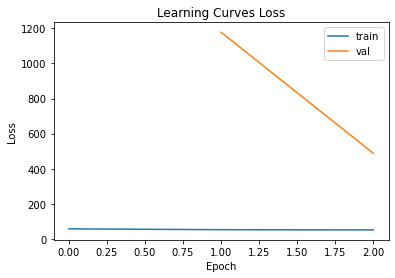

In [38]:
# plot learning curves Loss
from matplotlib import pyplot
pyplot.title('Learning Curves Loss')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

NameError: name 'history' is not defined

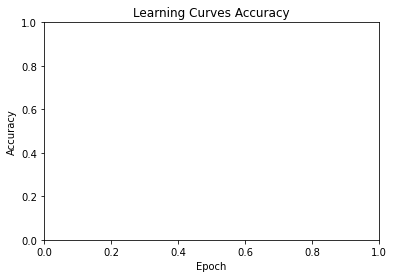

In [31]:
# plot learning curves Accuracy
from matplotlib import pyplot
pyplot.title('Learning Curves Accuracy')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.plot(history.history['BN_138_root_mean_squared_error'], label='train output 76*76')
pyplot.plot(history.history['val_BN_138_root_mean_squared_error'], label='val output 76*76')
pyplot.plot(history.history['BN_149_root_mean_squared_error'], label='train output 38*38')
pyplot.plot(history.history['val_BN_149_root_mean_squared_error'], label='val output 38*38')
pyplot.plot(history.history['BN_160_root_mean_squared_error'], label='train output 19*19')
pyplot.plot(history.history['val_BN_160_root_mean_squared_error'], label='val output 19*19')
pyplot.legend()
pyplot.show()

Making predictions

In [113]:
import random
image_ids = open('data/val.txt').read().strip().split()
test_image = random.choice(image_ids)
test_image



'17480'

In [114]:


# Pre-process the image


input_w, input_h = 608, 608
photo_filename = 'data/images/'+test_image+'.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  600 600
input image (1, 608, 608, 3)


In [115]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])

output [(1, 76, 76, 255), (1, 38, 38, 255), (1, 19, 19, 255)]


In [116]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, nb_box, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)   
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [140]:
# Compute the Yolo layers
obj_thresh = 0.659047
anchors = [[81,82,  135,169,  344,319], [10,14,  23,27,  37,58]]
scales_x_y = [1.0, 1.0]
boxes = list()
for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, 3, scales_x_y[i])

print("nb boxes detected; ",len(boxes))

grid_h,grid_w:  76 76
nb class:  80
grid_h,grid_w:  38 38
nb class:  80
nb boxes detected;  0


In [134]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [135]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [136]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [137]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.99)
print("nb boxes remaining; ",len(boxes))

nb boxes remaining;  21660


In [122]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [123]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.95
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

nb boxes remaining;  0


In [124]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

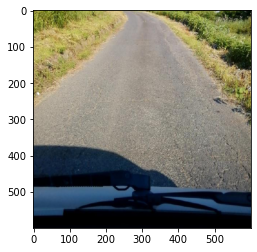

In [125]:
# Draw the result
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)